<a href="https://colab.research.google.com/github/indrasary/Bert_Symptom_Extractor/blob/main/BERT_NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. CONFIG

In [1]:
!pip install --upgrade torch==2.1.0

In [2]:
# import tensorflow as tf

In [3]:
import torch

In [4]:
USE_GDRIVE = True
if USE_GDRIVE:
  PROJECT_DIR = "drive/MyDrive/ColabNotebooks/"
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
else:
  PROJECT_DIR = "./"
device = "cuda" if torch.cuda.is_available() else "cpu"

print(PROJECT_DIR)

Mounted at /content/drive
drive/MyDrive/ColabNotebooks/


### Load and Analyze Data

In [5]:
!pip install --upgrade transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
data = pd.read_csv(PROJECT_DIR+'BERT_NER/data/overview-of-recordings.csv')
data1 = data[['phrase','prompt']]
data1.sample(5)

,phrase,prompt
5434,I feel pain in my knee when I climb the stairs.,Joint pain
6092,i was playing football and injuried with joint...,Joint pain
3085,"i was injured during football match, i was dia...",Injury from sports
2120,I feel like I can hardly breathe unless I get ...,Cough
428,My daughter had her ears pierced and one of he...,Infected wound


In [7]:
df=data1.copy()
df.isna().sum()

phrase    0
prompt    0
dtype: int64

In [8]:
df['prompt'].value_counts()

Acne                  328
Shoulder pain         320
Joint pain            318
Infected wound        306
Knee pain             305
Cough                 293
Feeling dizzy         283
Muscle pain           282
Heart hurts           273
Ear ache              270
Hair falling out      264
Head ache             263
Feeling cold          263
Skin issue            262
Stomach ache          261
Back pain             259
Neck pain             251
Internal pain         248
Blurry vision         246
Body feels weak       241
Hard to breath        233
Emotional pain        231
Injury from sports    230
Foot ache             223
Open wound            208
Name: prompt, dtype: int64

In [9]:
print('Total number of intents: %d'%(len(df['prompt'].value_counts().index)))

Total number of intents: 25


### 3. SPLIT DATA INTO TRAIN, VALIDATION, AND TEST SET

In [10]:
from sklearn.model_selection import train_test_split

X, sentence_test, y, intent_test = train_test_split(df.phrase, df.prompt, stratify = df.prompt,test_size=0.2, random_state=4612)
sentence_train, sentence_val, intent_train, intent_val = train_test_split(X, y, stratify = y,test_size=0.2, random_state=4612)

In [11]:
#sentence_train = s
print(sentence_train[0:80])

#sentence_val =
print(sentence_val[0:20])
#sentence_test =
print(sentence_test[0:20])

#intent_train = intent_train[0:80]
#intent_val = intent_val[0:20]
#intent_test = intent_test[0:20]

4601                         I have acne all over my face
5554    I have internal pain whenever I come down with...
6436                           Is pimples a skin disease?
3245                                       i cant breathe
61      My knee catches and hurts when I first stand u...
                              ...                        
4968                                   My ear is ringing.
4407                     i have disterbance in my emotion
1889                      My back hurts a lot when I bend
1843    My son got a tattoo several weeks ago and the ...
697                    i have muscle pain at my left leg.
Name: phrase, Length: 80, dtype: object
5521    I have a dull ache in my stomach.  It gets wor...
230                               I feel pain in the knee
5704                     Stomach pain after drinking milk
2582    I have difficulty in breathing in crowded places.
2536        I feel a great amount of pressure of my head.
2987    Feels like there are pin

In [12]:
print(f"#examples in training set:{ sentence_train.shape[0]}\n#examples in validation set:{ sentence_val.shape[0]}\n#examples in test set:{ sentence_test.shape[0]}")

#examples in training set:4262
#examples in validation set:1066
#examples in test set:1333


### 4. TOKENIZATION AND INPUT FORMATTING

The input text format should meet the format as follows:


*   tokenizing all sentences
*   padding and truncating all sentences to the same length.
*   Creating the attention masks which explicitly differentiate real tokens from [PAD] tokens. 0 or 1.
*   encoding the label "intent" to numbers. 25 intents to 25 numbers.
*   creating DataLoaders for our training, validation and test sets







In [13]:
# Defining some key variables that will be used later on in the training
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 64
EPSILON = 1e-08
EPOCHS = 4
LEARNING_RATE = 2e-5
SEED = 1215
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [14]:
max_len = 0
input = []
length=[]
# For every sentence...
for sent in sentence_train:

    # Tokenize the text and add special tokens--`[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    input.append(input_ids)
    length.append(len(input_ids))
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
    mean_len = sum(length)/len(length)
#39 tokens is the maximum number of tokens in a sentence (transcription). Also, a sentence has 14 tokens on average.
print('Max sentence length:%d \nMean sentence length:%d' % (max_len,mean_len))

Max sentence length:39 
Mean sentence length:14


In [15]:
# create a function to tokenize sentences.
def tokenize(sentence):
  batch = tokenizer(list(sentence),
                  is_pretokenized=False,
                  #Pad or truncate all sentences to the same length. Create the attention masks which explicitly differentiate real tokens from [PAD] tokens.
                  padding=True,
                  truncation=True,
                  return_tensors="pt")
  return batch

In [16]:
tok_train = tokenize(sentence_train)
tok_val = tokenize(sentence_val)
tok_test = tokenize(sentence_test)

Streaming output truncated to the last 5000 lines.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenized': False} not recognized.
Keyword arguments {'is_pretokenize

In [17]:
from sklearn.preprocessing import LabelEncoder
# encode "intent" to 25 number labels
LE = LabelEncoder()
label_train = torch.tensor((LE.fit_transform(intent_train)))
label_val = torch.tensor((LE.fit_transform(intent_val)))
label_test = torch.tensor((LE.fit_transform(intent_test)))

In [18]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(tok_train['input_ids'], tok_train['attention_mask'],label_train)
validation_dataset = TensorDataset(tok_val['input_ids'], tok_val['attention_mask'],label_val)
test_dataset = TensorDataset(tok_test['input_ids'], tok_test['attention_mask'],label_test)

In [19]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = TRAIN_BATCH_SIZE # Trains with this batch size.
        )

# For validation/test the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            validation_dataset, # The validation samples.
            sampler = SequentialSampler(validation_dataset), # Pull out batches sequentially.
            batch_size = VALID_BATCH_SIZE # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = VALID_BATCH_SIZE
        )

### 5. Train BERT classification model

In [20]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

## use pretained base(relatively small) BERT mdoel for sequence classification
#CUDA_LAUNCH_BLOCKING=1
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 25)
#model.cuda() # make pytorch run this model on GPU.

## use AdamW optimizer
optimizer = AdamW(model.parameters(),
                  lr = LEARNING_RATE,
                  eps = EPSILON) #very small number to prevent any division by zero

from transformers import get_linear_schedule_with_warmup

# Total number of training steps is [number of batches] x [number of epochs].
total_steps = len(train_dataloader) * EPOCHS

## Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [22]:
import time
import datetime

def format_time(elapsed):
    #Takes a time in seconds and returns a string hh:mm:ss
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [23]:
!pip install tensorboard

In [24]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('runs/Tensorboard')


In [25]:
# Start the training process:
import random
import torch

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

#torch.cuda.manual_seed_all(SEED)
def train(epochs):
  total_t0 = time.time() # Measure the total training time for the whole run.
  tr_loss = 0
  n_correct = 0
  nb_tr_steps = 0
  nb_tr_examples = 0

  # For each epoch...
  for epoch in range(0, epochs):
      print('======== Epoch {:} / {:} ========'.format(epoch + 1, epochs))
      print('Training...')

      t0 = time.time()     # Measure how long the training epoch takes.
      total_tr_loss = 0
      total_n_correct = 0
      total_nb_tr_examples = 0
      model.train()    # Put the model into training mode

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader, 0):
          # 'batch' contains three pytorch tensors:[0]: input ids, [1]: attention masks, [2]: labels
          input_ids = batch[0].to(device, dtype = torch.long)
          input_mask = batch[1].to(device, dtype = torch.long)
          labels = batch[2].to(device, dtype = torch.long)

          model.zero_grad()       #clear any previously calculated gradients

          outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask)
          loss_function = torch.nn.CrossEntropyLoss()
          loss = loss_function(outputs[0], labels) #`loss` is a Tensor containing a single value
          tr_loss += loss.item() #.item()` function just returns the Python value from the tensor
          total_tr_loss += loss.item()
          big_val, big_idx = torch.max(outputs[0], dim=1)
          n_correct += calcuate_accu(big_idx, labels)
          total_n_correct += calcuate_accu(big_idx, labels)
          nb_tr_steps += 1
          nb_tr_examples+=labels.size(0)
          total_nb_tr_examples+=labels.size(0)

          if step % 20==19:
              loss_step = tr_loss/nb_tr_steps
              accu_step = n_correct/nb_tr_examples # #correct examples/all examples
              print(f"Training Loss per 20 steps(batches): {loss_step}")
              print(f"Training Accuracy per 20 steps(batches): {accu_step}")
              elapsed = format_time(time.time() - t0)    # Calculate elapsed time in minutes.
              # Report progress.
              print('Batch {} of {}.  Elapsed: {:}.'.format(step+1, len(train_dataloader), elapsed))
              #writer.add_scalar('training loss', loss_step, (epoch +1)*len(trainloader) )
              tr_loss = 0;n_correct = 0;nb_tr_steps = 0;nb_tr_examples = 0

          loss.backward() # Perform a backward pass to calculate the gradients.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clip the norm of the gradients to 1.0. This is to help prevent the "exploding gradients" problem.
          optimizer.step()
          scheduler.step() # Update the learning rate.

      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)
      print('Validating...')

      # validation phase
      val_loss = 0
      val_n_correct = 0
      nb_val_steps = 0
      nb_val_examples = 0

      t0 = time.time()     # Measure how long the valid epoch takes.
      total_val_loss = 0
      total_n_val_correct = 0
      total_nb_val_examples = 0
      # For each batch of validation data...
      for step, batch in enumerate(validation_dataloader, 0):
          # 'batch' contains three pytorch tensors:[0]: input ids, [1]: attention masks, [2]: labels
          input_ids = batch[0].to(device, dtype = torch.long)
          input_mask = batch[1].to(device, dtype = torch.long)
          labels = batch[2].to(device, dtype = torch.long)

          outputs = model(input_ids, token_type_ids=None, attention_mask=input_mask)
          loss_function = torch.nn.CrossEntropyLoss()
          loss = loss_function(outputs[0], labels) #`loss` is a Tensor containing a single value
          val_loss += loss.item() #.item()` function just returns the Python value from the tensor
          total_val_loss += loss.item()
          big_val, big_idx = torch.max(outputs[0], dim=1)
          val_n_correct += calcuate_accu(big_idx, labels)
          total_n_val_correct += calcuate_accu(big_idx, labels)
          nb_val_steps += 1
          nb_val_examples+=labels.size(0)
          total_nb_val_examples+=labels.size(0)

          if step % 20==19:
              loss_step = val_loss/nb_val_steps
              accu_step = n_correct/nb_val_examples # #correct examples/all examples
              print(f"Validation Loss per 20 steps(batches): {loss_step}")
              print(f"Validation Accuracy per 20 steps(batches): {accu_step}")
              elapsed = format_time(time.time() - t0)    # Calculate elapsed time in minutes.
              # Report progress.
              print('Batch {} of {}.  Elapsed: {:}.'.format(step+1, len(validation_dataloader), elapsed))
              val_loss = 0; n_correct = 0; nb_val_steps = 0; nb_val_examples = 0


    # Calculate the average loss over all of the batches.
      train_loss_per_epoch = total_tr_loss / len(train_dataloader)
      train_accuracy_per_epoch=total_n_correct/total_nb_tr_examples
      train_losses.append(train_loss_per_epoch)
      train_accuracies.append(train_accuracy_per_epoch)

      valid_loss_per_epoch = total_val_loss / len(validation_dataloader)
      valid_accuracy_per_epoch=total_n_val_correct/total_nb_val_examples
      valid_losses.append(valid_loss_per_epoch)
      valid_accuracies.append(valid_accuracy_per_epoch)

      # Measure how long this epoch took.
      validation_time = format_time(time.time() - t0)

      print("")
      print("training loss per epoch: {0:.2f}".format(train_loss_per_epoch))
      print("training accuracy per epoch: {0:.2f}".format(train_accuracy_per_epoch))
      print("Training 1 epoch took: {:}".format(training_time))
      print("")

      print("validation loss per epoch: {0:.2f}".format(valid_loss_per_epoch))
      print("validation accuracy per epoch: {0:.2f}".format(valid_accuracy_per_epoch))
      print("validation 1 epoch took: {:}".format(validation_time))

In [26]:
train(epochs = EPOCHS)

======== Epoch 1 / 4 ========
Training...
Training Loss per 20 steps(batches): 3.2054264426231383
Training Accuracy per 20 steps(batches): 0.04375
Batch 20 of 134.  Elapsed: 0:04:07.
Training Loss per 20 steps(batches): 3.085178327560425
Training Accuracy per 20 steps(batches): 0.1125
Batch 40 of 134.  Elapsed: 0:08:00.
Training Loss per 20 steps(batches): 2.864337158203125
Training Accuracy per 20 steps(batches): 0.25
Batch 60 of 134.  Elapsed: 0:11:49.
Training Loss per 20 steps(batches): 2.5705428957939147
Training Accuracy per 20 steps(batches): 0.45625
Batch 80 of 134.  Elapsed: 0:15:34.
Training Loss per 20 steps(batches): 2.2978806614875795
Training Accuracy per 20 steps(batches): 0.609375
Batch 100 of 134.  Elapsed: 0:19:15.
Training Loss per 20 steps(batches): 1.9912233650684357
Training Accuracy per 20 steps(batches): 0.7640625
Batch 120 of 134.  Elapsed: 0:23:03.
Validating...

training loss per epoch: 2.58
training accuracy per epoch: 0.41
Training 1 epoch took: 0:25:39

va

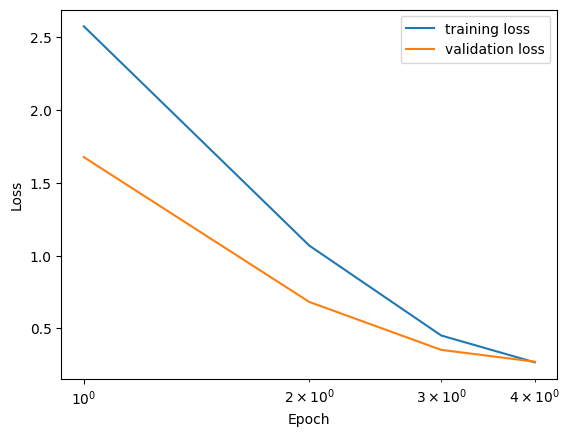

In [27]:
from matplotlib import pyplot as plt

plt.semilogx([1,2,3,4], train_losses, label = 'training loss')
plt.semilogx([1,2,3,4], valid_losses, label = 'validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

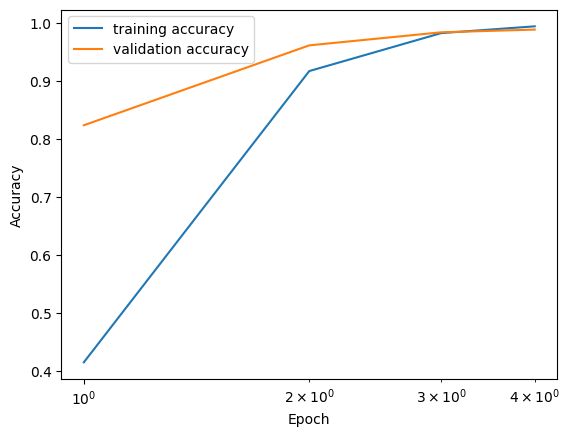

In [28]:
from matplotlib import pyplot as plt

plt.semilogx([1,2,3,4], train_accuracies, label = 'training accuracy')
plt.semilogx([1,2,3,4], valid_accuracies, label = 'validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### 6. Test the model on the validation set

In [29]:
# test the model on the validation set
def valid(model, validation_loader):
  model.eval()
  val_loss = 0
  nb_val_examples = 0
  n_correct = 0
  with torch.no_grad():
    for _, data in enumerate(validation_loader, 0):
      ids = data[0].to(device, dtype = torch.long)
      mask = data[1].to(device, dtype = torch.long)
      targets = data[2].to(device, dtype = torch.long)
      outputs = model(ids, mask)
      loss_function = torch.nn.CrossEntropyLoss()
      loss = loss_function(outputs[0], targets)
      val_loss += loss.item()
      big_val, big_idx = torch.max(outputs[0], dim=1)
      n_correct += calcuate_accu(big_idx, targets)
      nb_val_examples+=targets.size(0)

  val_ave_loss = val_loss/len(validation_loader)
  val_accu = (n_correct*100)/nb_val_examples
  print("Loss on validation/test data: %0.2f" % val_ave_loss)
  print("Accuracy on validation/test data: %0.2f%%" % val_accu)

  return

### 7. Obtain Test Error

In [30]:
valid(model, validation_dataloader)

Loss on validation/test data: 0.21
Accuracy on validation/test data: 99.16%


### 8. Save the model, tokenizer, and label

In [31]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = PROJECT_DIR+'BERT_NER/saved_bert_model_and_tokenizer'

# Create output directory if needed
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
# model_to_save.save_pretrained(output_dir+"/model.h5")
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

Saving model to drive/MyDrive/ColabNotebooks/BERT_NER/saved_bert_model_and_tokenizer


('drive/MyDrive/ColabNotebooks/BERT_NER/saved_bert_model_and_tokenizer/tokenizer_config.json',
 'drive/MyDrive/ColabNotebooks/BERT_NER/saved_bert_model_and_tokenizer/special_tokens_map.json',
 'drive/MyDrive/ColabNotebooks/BERT_NER/saved_bert_model_and_tokenizer/vocab.txt',
 'drive/MyDrive/ColabNotebooks/BERT_NER/saved_bert_model_and_tokenizer/added_tokens.json')

In [32]:
df_label = pd.DataFrame(tuple(zip(range(25),LE.classes_)), columns=['id','intent'])
df_label.to_pickle( PROJECT_DIR+'BERT_NER/saved_bert_model_and_tokenizer/df_label.pkl')

In [ ]:
# Copy the model files to a directory in Google Drive.
!cp -r  PROJECT_DIR+'BERT_NER/saved_bert_model_and_tokenizer/df_label.pkl'

cp: missing destination file operand after 'PROJECT_DIR+BERT_NER/saved_bert_model_and_tokenizer/df_label.pkl'
Try 'cp --help' for more information.


### 9. Prepare the model for deployment

*   Load the saved model, tokenizer and labels
*   Create a medical_symptom_detector function with the loaded model, tokenizer and labels, which helps predict the medical intent of a medical message.
*   Test the detector on an unseen example







In [33]:
#### load the model and build the detector for deployment
#!pip install transformers
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification

input_dir = PROJECT_DIR+'BERT_NER/saved_bert_model_and_tokenizer/'

loaded_model = BertForSequenceClassification.from_pretrained(input_dir, ignore_mismatched_sizes=True)
loaded_model.eval()
loaded_tokenizer = BertTokenizer.from_pretrained(input_dir)
loaded_df_label = pd.read_pickle(PROJECT_DIR+'BERT_NER/saved_bert_model_and_tokenizer/df_label.pkl')

In [34]:
loaded_model.eval()
loaded_tokenizer = BertTokenizer.from_pretrained(input_dir)
loaded_df_label = pd.read_pickle(PROJECT_DIR+'BERT_NER/saved_bert_model_and_tokenizer/df_label.pkl')

In [35]:
# test the model on an unseen example

def medical_symptom_detector(intent):

  pt_batch = loaded_tokenizer(
  intent,
  padding=True,
  truncation=True,
  return_tensors="pt")

  pt_outputs = loaded_model(**pt_batch)
  __, id = torch.max(pt_outputs[0], dim=1)
  prediction = loaded_df_label.iloc[[id.item()]]['intent'].item()
  print('You may have a medical condition: %s. Would you like me to transfer your call to your doctor?'%(prediction))
  return

In [42]:
input = "I'm just having a lot of chest pain and and so I thought I should get it checked out"
medical_symptom_detector(input)

You may have a medical condition: Heart hurts. Would you like me to transfer your call to your doctor?
